Need to simplify the loading and setting up of a new tracklog

We should immediately load the GPS to get the proper timings so 
everything correlates between IGC and datalogged, and then be able to 
plot sets of IGCs at a time.

We should load Q records with the correct datetime, and offset the others 
by Rdatetime0

We need the R record because it has the date in it!


Things to do:
* Plot terrain underlay
* Interactive plot 2 flights at a time (list of fds)
* allow use of IGC data
* Clarify Hough transform calculations as a means to generate a vx vy for the wind
* Calculate wind direction within short section using Hough
* Plot whiskers for bank angles

Done:
* Plot vario
* Calculate barometric conversion from GPS
* Plot colour by velocity
* Plot whiskers for orientation
* Subtract wind direction from position (or velocity)



In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib

fname = "data/022.TXT"
fname = "data/022-short.TXT"
fname = "data/029.TXT"

fd = loaders.FlyDat(fname, knowndate="2018-08-05")


BAD VALUES 3000 [(2129, 'Qt00069715u02130AE0y01E8DB6CxFFE4AC41a0032\n'), (2129, 'Qt000697D6u02130BA8y01E8DB6FxFFE4AC3Ea0031\n'), (2129, 'Qt00069896u02130C70y01E8DB72xFFE4AC3Aa0031\n')]
Made for Q 14077 last index 11077
Setting new Rdatetime0 2018-08-05 09:32:50.529380066 with std 20.13
Made for V 19980 last index 19980


In [2]:
from hacktrack import clickables

In [3]:
from hacktrack import clickables
clickables.plotinteractivegpstrack(fd)


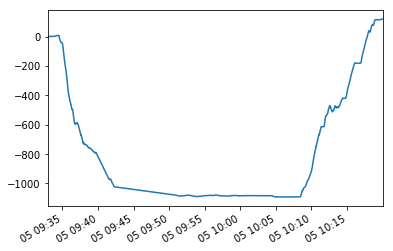

In [9]:
fd.pQ.x.plot()

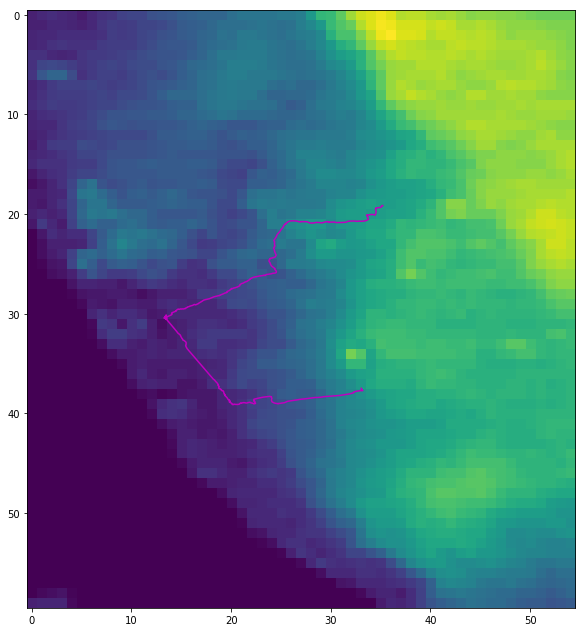

In [13]:
tp = utils.TerrainPlot(fd.pQ, tiledirectory="/home/julian/hgstuff/hgtterrains")
tp.plotterrain(plt)
tp.plotgps(plt, fd.pQ, "m")


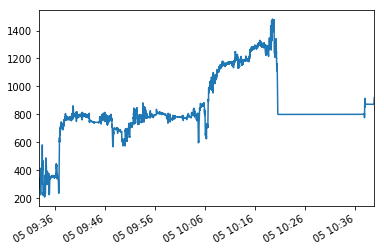

In [27]:
import numpy
#g = numpy.sqrt(fd.pZ.gx**2 + fd.pZ.gy**2 + fd.pZ.gz**2)
#plt.plot(g)
#a = numpy.sqrt(fd.pZ.ax**2 + fd.pZ.ay**2 + fd.pZ.az**2)
#plt.plot(a)
fd.pZ.heading.plot()

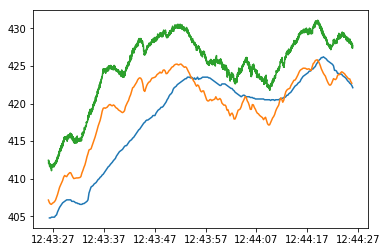

In [18]:
plt.plot(alt)
plt.plot(balt)
fbalt = baro*k.slope + k.intercept
plt.plot(fbalt+5)

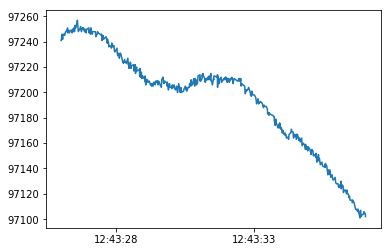

In [21]:
plt.plot(baro.iloc[:500])


In [8]:
fdI = loaders.FlyDat("data/longmynd15k.IGC")

6328

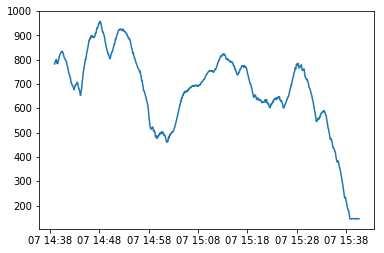

In [26]:
k = fdI.pIGC.iloc[4500:]
plt.plot(k.altb)

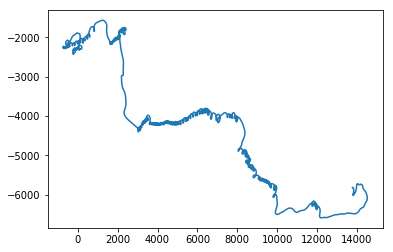

In [24]:
k = fdI.pIGC.iloc[4500:]
plt.plot(k.x, k.y)

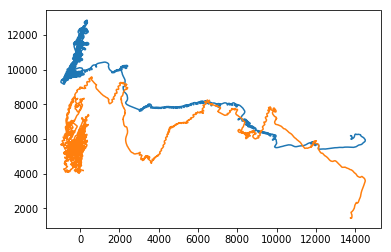

In [17]:
plt.plot(fdI.pIGC.x, fdI.pIGC.y+12000)
plt.plot(fdI.pIGC.x, fdI.pIGC.altb*10)

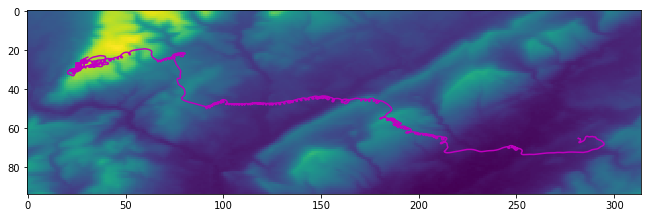

In [48]:
q = fdI.pIGC.iloc[-2200:]
tp = utils.TerrainPlot(q, tiledirectory="/home/julian/hgstuff/hgtterrains")
tp.plotterrain(plt)
tp.plotgps(plt, q, "m")


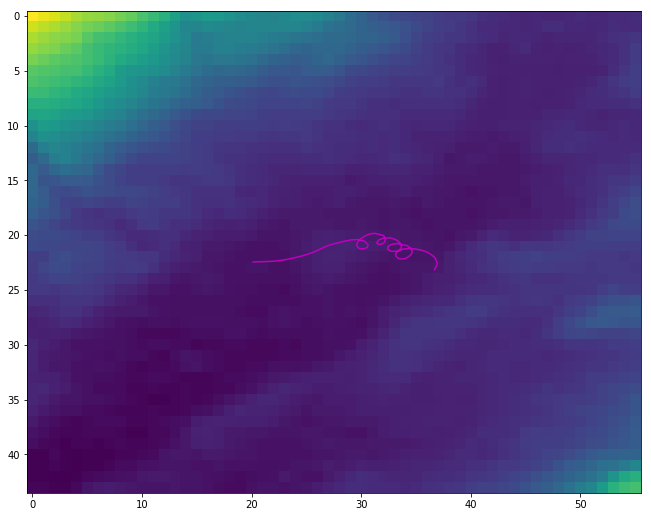

In [43]:
q = fdI.pIGC.iloc[-260:-190]
tp = utils.TerrainPlot(q, tiledirectory="/home/julian/hgstuff/hgtterrains")
tp.plotterrain(plt)
tp.plotgps(plt, q, "m")


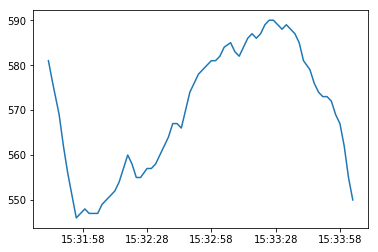

In [44]:
plt.plot(q.altb)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib

fdI = loaders.FlyDat("data/885B0912.IGC", fdother=fd)


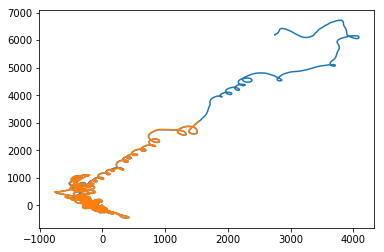

In [3]:
plt.plot(fdI.pIGC.x, fdI.pIGC.y)
plt.plot(fd.pQ.x, fd.pQ.y)

In [24]:
# Hough transform calculations (to get the velocity vectors, instead of by eye)
# define the grid array of velocities as between -10 and +10m/s
wsx = numpy.linspace(-5, 5, 21)
wsy = numpy.linspace(-5, 5, 21)
td = 2  # seconds between each sample
wxx, wyy = numpy.meshgrid(wsx, wsy)

# with too narrow a band (large houghspread) the single point sample in each cell is not 
# representative of the overall value that should be assigned to the cell
def F(p0x, p0y, p1x, p1y, p2x, p2y, houghspread, wxx, wyy):
    D = numpy.exp(-houghspread*(((p1x - p0x - wxx*td)**2 + (p1y - p0y - wyy*td)**2) - 
                                ((p2x - p1x - wxx*td)**2 + (p2y - p1y - wyy*td)**2))**2)
    return D / sum(sum(D))


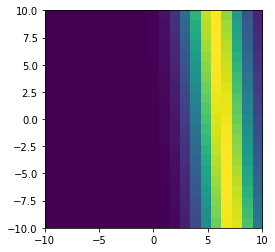

In [5]:
# example showing of the probability field
houghspread = 0.0002
Hextents = [wsx[0], wsx[-1], wsy[0], wsy[-1]]
D = F(0, 0, 10, 0, 26.4, 0.5, houghspread, wxx, wyy)
plt.imshow(D, origin='lower', extent=Hextents)

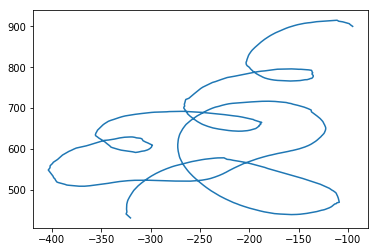

In [16]:
pQ = fd.pQ[fd.t0:fd.t1]
len(pQ)
plt.plot(pQ.x, pQ.y)

Peak value 0.0 -1.0


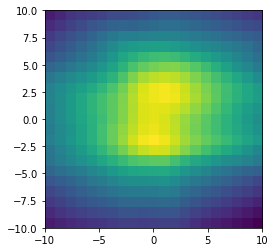

In [26]:
# sum these probability fields for sets of three points in the tracklog
def houghtrack(tlx, tly, houghspread):
    H = numpy.zeros((len(wsx), len(wsy)))
    for i in range(2, len(tlx)):
        H += F(tlx[i-2], tly[i-2], tlx[i-1], tly[i-1], tlx[i], tly[i], 
               houghspread, wxx, wyy)
    return H

tlx, tly = pQ.x, pQ.y
H = houghtrack(tlx, tly, houghspread*100)
plt.imshow(H, origin='lower', extent=Hextents)
iy, ix = numpy.unravel_index(H.argmax(), H.shape)
print("Peak value", wsx[ix], wsy[iy])


In [10]:
# to make the short version
t = open("data/022.TXT").read()
import re
print(len(t))
t1 = re.sub("N.*?\n", "", t)
print(len(t1))
k1 = t1.find("\n\n")
t1[:k1+2]
s1 = k1+10000018
s2 = k1+10360050
t2 = t1[s1:s2]
f = open("data/022-short.TXT", "w")
f.write(t1[:k1+2]+t1[s1:s2])
f.close()

26105569
24487596
